In [ ]:
https://github.com/dim4o/gender-recognizer/blob/master/Gender%20Classification.ipynb
    https://github.com/google-research/google-research/blob/2f8d5e788c6295d71f5400806e5ed1e2a00f8f19/maml_nonexclusive/maml_classification/maml.py

In [1]:
import os
import urllib
import tarfile
import re
from shutil import copyfile
import random
import time
import itertools
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import urllib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, SelectPercentile
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Constants
NUMBER_OF_SAMPLES = 2900
RESIZE_SHAPE = (40, 40)
FEMALE_CLASS = 0
MALE_CLASS = 1

In [2]:
import os
os.chdir(r'D:\2nd_semester\bigdatascience\meta\horse-or-human\train')

In [3]:

directory_female = r"D:\2nd_semester\bigdatascience\meta\horse-or-human\train\horses\\"
directory_male = r"D:\2nd_semester\bigdatascience\meta\horse-or-human\train\humans\\"


In [4]:
# test print for the selected names
female_image_names = os.listdir(directory_female)
male_image_names = os.listdir(directory_male)
print(len(female_image_names))
print(len(male_image_names))

500
527


# Dimensionality reduction
Image transformations
Now I'll extract the features from the image following these actions:

Get the original image
Convet the image to grayscale
Define the region of interests. Use haar faces to detect a face (if exists) on the image. If there is more than one face, I'll get the square with the larger area.
Crop the square from the gray image
Apply gaussian kernel over the cropped image to reduce the noise.
Resize the image to 40x40px

In [7]:
gender_faces_data = None
gender_faces_data = np.empty(shape=(0,RESIZE_SHAPE[0]*RESIZE_SHAPE[1]+1)) #64*64+1
face_cascade = cv2.CascadeClassifier(r'D:\2nd_semester\bigdatascience\project\face_data\face.xml')

def extract_features(image_path, label):
    """ Extracts features from a image
    :param image_path: the path to the image
    :param label: the label of the image
    :return: extracted features from the image with the corresponding label as a row matrix
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    row = None
    '''faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces is not ():
        face = sorted(faces, key=lambda x: (x[2] * x[3]), reverse=True)[0]
        x, y, width, height = face
        face_gray = gray[y: y + height, x: x + width]
        
        # apply Gaussian kernel
        kernel = np.ones((3,3),np.float32)/9
        face_gray = cv2.filter2D(face_gray,-1,kernel)
        
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        row = np.append(resized.ravel(), label)'''

    return np.append((cv2.resize(gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)),label)

def append_data(prefix_path, label, gender_faces_data):
    """ Appends data to a numpy array"""
    image_names = os.listdir(prefix_path)
    for image_path in image_names:
        # print(image_path)
        curr_row = extract_features(prefix_path + image_path, label)
        if curr_row is not None:
            gender_faces_data = np.append(gender_faces_data, [curr_row], axis=0)
        
    return gender_faces_data

In [8]:
# Append the female faces
gender_faces_data = append_data(directory_female, FEMALE_CLASS, gender_faces_data)
female_data = gender_faces_data

# Append the male faces
gender_faces_data = append_data(directory_male, MALE_CLASS, gender_faces_data)

print("Females count: {}".format(female_data.shape[0]))
print("Males count: {}".format(gender_faces_data.shape[0] - female_data.shape[0]))
print("Gender data shape: {}".format(gender_faces_data.shape))

Females count: 500
Males count: 527
Gender data shape: (1027, 1601)


In [9]:
# Suffle the data
np.random.shuffle(gender_faces_data)
gender_faces_data

array([[ 15.,  17.,  60., ..., 128., 105.,   0.],
       [198., 175., 196., ..., 165., 165.,   1.],
       [167., 165., 165., ..., 199., 218.,   0.],
       ...,
       [199., 200., 200., ..., 211., 198.,   1.],
       [156., 159., 149., ..., 226., 228.,   1.],
       [217., 210., 201., ..., 198., 191.,   0.]])

In [10]:
np.savetxt(r'D:\2nd_semester\bigdatascience\meta\horse-or-human\human_animal__data_40x40_large_2.csv', gender_faces_data.astype(np.int), delimiter=",")

In [2]:
# Time 1-2 min, size ~200Mb
# downloads the dataset if does not exists
dataset_file = r'D:\2nd_semester\bigdatascience\meta\horse-or-human\human_animal__data_40x40_large_2.csv'


gender_faces_data = pd.read_csv(dataset_file, sep=',', header=None)
gender_faces_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,15.0,17.0,60.0,40.0,20.0,51.0,47.0,26.0,18.0,14.0,...,134.0,132.0,115.0,133.0,140.0,135.0,119.0,128.0,105.0,0.0
1,198.0,175.0,196.0,181.0,172.0,177.0,178.0,163.0,161.0,153.0,...,177.0,180.0,162.0,179.0,177.0,161.0,187.0,165.0,165.0,1.0
2,167.0,165.0,165.0,165.0,163.0,162.0,163.0,164.0,163.0,164.0,...,215.0,215.0,218.0,236.0,222.0,227.0,211.0,199.0,218.0,0.0
3,174.0,175.0,174.0,174.0,174.0,174.0,174.0,174.0,174.0,175.0,...,62.0,31.0,30.0,13.0,21.0,21.0,17.0,57.0,71.0,0.0
4,29.0,28.0,28.0,28.0,28.0,27.0,27.0,26.0,26.0,26.0,...,141.0,143.0,163.0,159.0,146.0,142.0,139.0,132.0,158.0,1.0


In [3]:
# get features
features = gender_faces_data.to_numpy()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

# get labels
labels = gender_faces_data.to_numpy()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

(1027, 1600)
(1027,)
[0. 1. 0. ... 1. 1. 0.]


In [4]:
# calculates the final counts
unique, count = np.unique(labels, return_counts=True)
print("Females count: {}".format(count[0]))
print("Males count: {}".format(count[1]))
# out = np.histogram(labels, bins=labels)
print(dict(zip(unique, count)))

Females count: 500
Males count: 527
{0.0: 500, 1.0: 527}


# Choice of the best features
It is difficult to find the best PCA parameters but I can make very rough approximations with something like grid search.

In [5]:
print("Features shape: {}".format(features.shape))
features_counts = [80, 140, 200, 260, 320, 380, 440, 1000]
test_scores = []
train_scores = []
for f_count in features_counts:
    print("Reducing features to {} ...".format(f_count))
    pca = PCA(n_components=f_count)

    pca.fit(features)
    reduced_features = pca.transform(features)
    
    features_train, features_test, labels_train, labels_test = train_test_split(
        reduced_features, labels, train_size=0.7, test_size=0.3, random_state=0)
    
    logistic_regression = LogisticRegression(C=0.001)
    logistic_regression.fit(features_train, labels_train)
    
    test_score = logistic_regression.score(features_test, labels_test)
    train_score = logistic_regression.score(features_train, labels_train)
    
    print("    train_score: {}".format(train_score))
    print("    test_score: {}".format(test_score))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
print("Finished.")

Features shape: (1027, 1600)
Reducing features to 80 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

    train_score: 0.8802228412256268
    test_score: 0.8122977346278317
Reducing features to 140 ...
    train_score: 0.9846796657381616
    test_score: 0.8317152103559871
Reducing features to 200 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.8543689320388349
Reducing features to 260 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.8576051779935275
Reducing features to 320 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.8737864077669902
Reducing features to 380 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.8511326860841424
Reducing features to 440 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.8737864077669902
Reducing features to 1000 ...
    train_score: 1.0
    test_score: 0.8640776699029126
Finished.


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


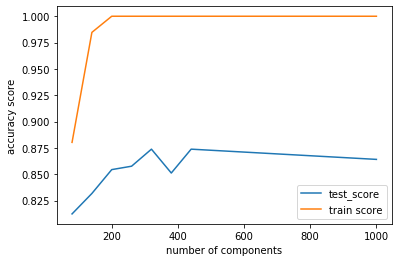

In [6]:

plt.plot(features_counts, test_scores)
plt.plot(features_counts, train_scores)
plt.legend(["test_score", "train score"])
plt.xlabel("number of components")
plt.ylabel("accuracy score")
plt.show()

# Model selection
As we have seen, the data is well balanced and therefore I will choose Accuracy Score for metric. Also I will use Learning Curve, ROC curve and Confusion Matrix to analyze the results.

In [7]:
gender_faces_data = pd.read_csv(r'D:\2nd_semester\bigdatascience\meta\horse-or-human\human_animal__data_40x40_large_2.csv', sep=',', header=None)

print(gender_faces_data.shape)
gender_faces_data.head()

(1027, 1601)


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,15.0,17.0,60.0,40.0,20.0,51.0,47.0,26.0,18.0,14.0,...,134.0,132.0,115.0,133.0,140.0,135.0,119.0,128.0,105.0,0.0
1,198.0,175.0,196.0,181.0,172.0,177.0,178.0,163.0,161.0,153.0,...,177.0,180.0,162.0,179.0,177.0,161.0,187.0,165.0,165.0,1.0
2,167.0,165.0,165.0,165.0,163.0,162.0,163.0,164.0,163.0,164.0,...,215.0,215.0,218.0,236.0,222.0,227.0,211.0,199.0,218.0,0.0
3,174.0,175.0,174.0,174.0,174.0,174.0,174.0,174.0,174.0,175.0,...,62.0,31.0,30.0,13.0,21.0,21.0,17.0,57.0,71.0,0.0
4,29.0,28.0,28.0,28.0,28.0,27.0,27.0,26.0,26.0,26.0,...,141.0,143.0,163.0,159.0,146.0,142.0,139.0,132.0,158.0,1.0


In [18]:
features = gender_faces_data.to_numpy()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

(1027, 1600)


In [8]:
labels = gender_faces_data.to_numpy()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel()
print(labels.shape)
print(labels)

(1027,)
[0. 1. 0. ... 1. 1. 0.]


# Define util functions

In [20]:
def plot_roc_curve(estimator, features_test, labels_test, title):
    """ Plots ROC curve"""
    logit_roc_auc = roc_auc_score(labels_test, estimator.predict(features_test))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        labels_test, estimator.predict_proba(features_test)[:,1])
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='{} (area = {:0.2f})'.format(title, logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    return plt

In [21]:
def print_grid_search_results(grid_search_pipeline, splits):
    """ Prints reformated version of the cv_results_
    :param grid_search_pipeline: grid_search estimator
    :param splits: the number of the kFold splits
    :return: table with parameters
    """
    results = pd.DataFrame(grid_search_pipeline.cv_results_)
    results = results.drop(['mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time', 'params'], axis=1)
    columns = columns={"param_pca__n_components": "param_pca", "param_classifier__C": "param_C", 
                       "mean_test_score": "mean_test","mean_train_score": "mean_train", "rank_test_score": 
                       "rank_test", "param_clf__n_estimators": "n_estimators"}
    for i in range(0, splits):
        columns["split" + str(i) + "_train_score"]="split" + str(i) + "_train"
        columns["split" + str(i) + "_test_score"]="split" + str(i) + "_test"
    results = results.rename(columns=columns)
    results.sort_values(by='rank_test', inplace=True)
    return results.head(len(grid_search_pipeline.cv_results_['params']))

In [22]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    For more info see the origanl documtation here: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [23]:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Logistic Regression model
Basic Logistic Regression
I will create a pipeline for the models because it is convenient to use not only during the training but also during the use of the model. I can simply call pipeline_model.predict(...) and it will handle the PCA and Scaler transformations for the input data. It is therefore a prerequisite for fewer mistakes. On the other hand, invoking PCA and Scaler every time when creating each model will reduce performance. But for the purpose of this study, this is not so important.

In [24]:

# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=42)

In [25]:
# creates a pipeline for Logistic Regression
logistic_regression_pipe = None
logistic_regression = LogisticRegression(random_state=42)
logistic_regression_pipe = Pipeline(steps=[('scaler_before', StandardScaler()), 
                          ('pca', PCA(n_components=440)),
                          ('scaler_after', StandardScaler()),
                          ('classifier', logistic_regression)])

In [26]:
classifier = LogisticRegression(random_state = 0, C=150)

In [27]:

# fit the basic Logistic Regression model
logistic_regression_pipe.fit(features_train, labels_train)

Pipeline(memory=None,
         steps=[('scaler_before',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=440,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scaler_after',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [13]:
from operator import itemgetter
rand_indices = random.sample(range(len(features_train)),200)
XTrain = np.array(itemgetter(*rand_indices)(features_train))
YTrain = np.array(itemgetter(*rand_indices)(labels_train))
logistic_regression_pipe.fit(XTrain,YTrain)

Pipeline(memory=None,
         steps=[('scaler_before',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scaler_after',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [14]:
features_train.shape

(3837, 1600)

In [15]:
XTrain.shape

(200, 1600)

In [34]:
from sklearn.metrics import log_loss
class MAML(object):
    def __init__(self):
        
        #initialize number of tasks i.e number of tasks we need in each batch of tasks
        self.num_tasks = 1
        
        #number of samples i.e number of shots  -number of data points (k) we need to have in each task
        self.num_samples = 500

        #number of epochs i.e training iterations
        self.epochs = 10000
    
        #hyperparameter for the inner loop (inner gradient update)
        self.alpha = 0.00001
        
        #hyperparameter for the outer loop (outer gradient update) i.e meta optimization
        self.beta = 0.00001
       
        #randomly initialize our model parameter theta
        self.theta = np.random.normal(size=150).reshape(1, 150)
      
    #define our sigmoid activation function  
    def sigmoid(self,a):
        
        return 1.0 / (1 + np.exp(-a))
    ## human vs cat-dog

    
    
    #now let us get to the interesting part i.e training :P
    def train(self):
        
        #for the number of epochs,
        for e in range(self.epochs):        
            
            self.theta_ = []
            #tasks = [human_animal(),male_female()]
            
            #for task i in batch of tasks
            for i in range(self.num_tasks):
               
                #sample k data points and prepare our train set
                #XTrain, YTrain = sample_points(self.num_samples)
                rand_indices = random.sample(range(len(features_train)),self.num_samples)
                XTrain = np.array(itemgetter(*rand_indices)(features_train))
                YTrain = np.array(itemgetter(*rand_indices)(labels_train))
                logistic_regression_pipe.fit(XTrain,YTrain)
                # logic to get data from images directory


                #a = np.matmul(XTrain, self.theta)
                #YHat = self.sigmoid(a)
                YHat = logistic_regression_pipe.predict(XTrain)
                # call appropriate task and make prediction , tasks[i].

                #since we are performing classification, we use cross entropy loss as our loss function
                #loss = ((np.matmul(-YTrain.T, np.log(YHat)) - np.matmul((1 -YTrain.T), np.log(1 - YHat)))/self.num_samples)[0][0]
                loss = log_loss(YTrain, YHat)
                pca = PCA(n_components=150)
                pca.fit(XTrain)
                XTrain = pca.transform(XTrain)
                
                #minimize the loss by calculating gradients
                gradient = np.matmul(XTrain.T, (YHat - YTrain)) / self.num_samples

                #update the gradients and find the optimal parameter theta' for each of tasks
                self.theta_.append(self.theta - self.alpha*gradient)
                
     
            #initialize meta gradients
            meta_gradient = np.zeros(self.theta.shape)
                        
            for i in range(self.num_tasks):
            
                #sample k data points and prepare our test set for meta training
                #XTest, YTest = sample_points(10)
                rand_indices = random.sample(range(len(features_test)),200)
                XTest = np.array(itemgetter(*rand_indices)(features_test))
                YTest = np.array(itemgetter(*rand_indices)(labels_test))
                YPred = logistic_regression_pipe.predict(XTest)
                pca = PCA(n_components=150)
                pca.fit(XTest)
                XTest = pca.transform(XTest)

                #predict the value of y
                #a = np.matmul(XTest, self.theta_[i])
                
                #YPred = self.sigmoid(a)
                           
                #compute meta gradients
            
                meta_gradient += np.matmul(XTest.T, (YPred - YTest)) / self.num_samples

  
            #update our randomly initialized model parameter theta with the meta gradients
            self.theta = self.theta-self.beta*meta_gradient/self.num_tasks
            #print(self.theta.shape)
            logistic_regression_pipe.named_steps['classifier'].coef_ = self.theta
            #print( sum(self.theta == logistic_regression_pipe.named_steps['classifier'].coef_) )
            if e % 100 == 0:
                print(loss)
            #if loss < 0.3:
             #   break
         

In [35]:
MAML().train()

1.3124878957603503
1.5197221533246748
0.20723425756432542
1.9341954660379046
1.0361776846010649
1.726956410888999
1.5197221533246745
1.7960371620685411
1.5888029045042167
1.4506509973142951
1.7269564108889992
0.8980209798265616
2.003276217217447
2.0723537700072683
1.105258435780607
0.3453925615336889
0.7598642750520586
2.6940549435053813
0.6217075702775555
0.8289386294521591
2.1414297236022293
1.5197221533246745
1.5887981069196357
1.5197269509092557
0.8980193806317013
0.8980177814368409
0.48355086550305243
1.5888029045042167
0.8980177814368409
0.898017781436841
0.5526332158774548
1.3124974909295126
1.4506446005348534
0.3453909623388285
0.9670985326163829
1.3124910941500711
0.9670985326163832
0.690781924677656
1.5197269509092557
0.4144701143235103
2.7631388930746437
2.5558966395360176
1.1743327901807077
2.9012923994594266
1.9341954660379046
1.5197221533246745
0.34539256153368886
2.4177479307358167
0.8980193806317012
1.174331190985847
0.06907915198468273
1.5888029045042167
2.210508875586

In [13]:
classifier.fit(features_train, labels_train)
coef = classifier.coef_[0]

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
logistic_regression_pipe.named_steps['classifier'].coef_.shape

(1, 150)

In [14]:
print (coef)

[ 2.42034540e-03  4.38542456e-05 -2.22780118e-03 ...  9.60718626e-04
  1.08336863e-03 -3.75707659e-03]


In [15]:
print(len(coef))

1600


In [36]:
print("Basic logistic regression test accuracy score: {}".format(
    logistic_regression_pipe.score(features_test, labels_test)))
print("Basic logistic regression train accuracy score: {}".format(
    logistic_regression_pipe.score(features_train, labels_train)))
print("Basic logistic regression F1 score: {}".format(
    f1_score(labels_test, logistic_regression_pipe.predict(features_test))))

Basic logistic regression test accuracy score: 0.48145896656534953
Basic logistic regression train accuracy score: 0.436799583007558
Basic logistic regression F1 score: 0.4618296529968455


In [28]:
print("Basic logistic regression test accuracy score: {}".format(
    logistic_regression_pipe.score(features_test, labels_test)))
print("Basic logistic regression train accuracy score: {}".format(
    logistic_regression_pipe.score(features_train, labels_train)))
print("Basic logistic regression F1 score: {}".format(
    f1_score(labels_test, logistic_regression_pipe.predict(features_test))))

Basic logistic regression test accuracy score: 0.8932038834951457
Basic logistic regression train accuracy score: 1.0
Basic logistic regression F1 score: 0.9054441260744985


The result seems fairly good but we need to check whether this is due to the separation of data (see the difference between the train score and the test score). Moreover we also need to look for better parameters. So we have to make kFold cross-validation and grid search.

# Tune the Logistic Regression params

In [30]:
# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

params = dict(classifier__C=[0.0001, 0.001, 0.01, 1],
              #classifier__penalty=['l1', 'l2'],
              pca__n_components=[440, 320])

# init kFold validation
kfold = StratifiedKFold(n_splits=8)

# Grid search for the best Logistic Regression parameters
grid_search_logistic_regresion = GridSearchCV(
    logistic_regression_pipe, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)

grid_search_logistic_regresion.fit(features_train, labels_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler_before',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=440, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('scaler_after',
                                        StandardScal...
                                                           intercept_scaling=1,
                                                  

In [31]:
grid_search_logistic_regresion.best_params_

{'classifier__C': 0.01, 'pca__n_components': 320}

In [32]:
print("Logistic Regression Grid Search best score: {}".format(grid_search_logistic_regresion.best_score_))

Logistic Regression Grid Search best score: 0.8578963795255931


In [33]:

print_grid_search_results(grid_search_logistic_regresion, splits=8)

,param_C,param_pca,split0_test,split1_test,split2_test,split3_test,split4_test,split5_test,split6_test,split7_test,...,split0_train,split1_train,split2_train,split3_train,split4_train,split5_train,split6_train,split7_train,mean_train,std_train_score
5,0.01,320,0.833333,0.844444,0.888889,0.833333,0.844444,0.933333,0.853933,0.831461,...,0.988854,0.988854,0.987261,0.992038,0.985669,0.987261,0.993641,0.988871,0.989056,0.002448
7,1,320,0.833333,0.844444,0.855556,0.833333,0.844444,0.866667,0.797753,0.820225,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,1,440,0.822222,0.788889,0.811111,0.811111,0.833333,0.866667,0.876404,0.831461,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.01,440,0.822222,0.811111,0.833333,0.800000,0.811111,0.888889,0.842697,0.831461,...,0.996815,0.996815,1.000000,1.000000,1.000000,0.998408,0.998410,0.996820,0.998409,0.001378
3,0.001,320,0.844444,0.811111,0.844444,0.744444,0.811111,0.833333,0.808989,0.752809,...,0.952229,0.966561,0.947452,0.958599,0.942675,0.945860,0.955485,0.953895,0.952844,0.007167
2,0.001,440,0.833333,0.744444,0.777778,0.777778,0.811111,0.855556,0.842697,0.786517,...,0.987261,0.984076,0.988854,0.992038,0.982484,0.984076,0.990461,0.985692,0.986868,0.003161
0,0.0001,440,0.533333,0.533333,0.522222,0.522222,0.522222,0.522222,0.528090,0.528090,...,0.525478,0.525478,0.527070,0.527070,0.527070,0.527070,0.526232,0.526232,0.526462,0.000664
1,0.0001,320,0.533333,0.533333,0.522222,0.522222,0.522222,0.522222,0.528090,0.528090,...,0.525478,0.525478,0.527070,0.527070,0.527070,0.527070,0.526232,0.526232,0.526462,0.000664


# Learning curve
The Learning curve would help us figure out if our algorithm suffers from a high bias or high variance

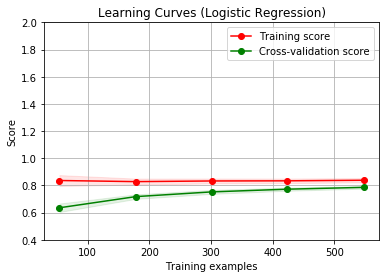

In [41]:

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.9, random_state=0)
scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components=150).fit_transform(scaled_features)
linear_regression_estimator = LogisticRegression(C=0.001)

plot_learning_curve(linear_regression_estimator, title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
plt.show()

It can be seen from the figure above that with appropriate regularization or increasing in the number of samples, we can reduce the variance between test data and train data significantly but we can not achieve a score greater than 0.85. This means that in order to achieve better results we may change the bias because we have high bias problem - the curves are close to each other and both of them have lower than desired score.

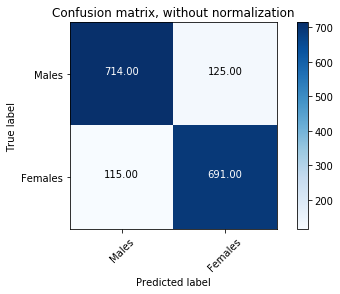

In [42]:
cnf_matrix = confusion_matrix(labels_test, grid_search_logistic_regresion.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), 
                      title='Confusion matrix, without normalization')
plt.show()

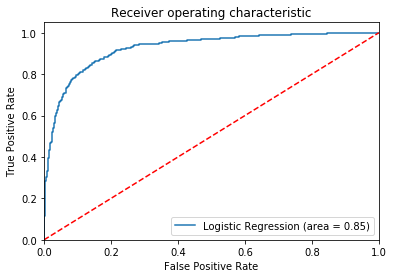

In [43]:
estimator = grid_search_logistic_regresion.best_estimator_
roc = plot_roc_curve(estimator, features_test, labels_test, title="Logistic Regression")
roc.show()

# Train SVM model

In [44]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

In [45]:
linear_svm = LinearSVC(random_state=42)
linear_svm_pipeline = Pipeline(steps=[('scl', StandardScaler()), 
                               ('pca', PCA(n_components=200, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', linear_svm)])

linear_svm_pipeline.fit(features_train, labels_train)

D:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scl_2',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=42,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [46]:
print("Train score: {}".format(linear_svm_pipeline.score(features_train, labels_train)))
print("Test score: {}".format(linear_svm_pipeline.score(features_test, labels_test)))
print("Diff score: {}".format(
    linear_svm_pipeline.score(features_train, labels_train) - linear_svm_pipeline.score(features_test, labels_test)))

Train score: 0.8694292415949961
Test score: 0.8486322188449849
Diff score: 0.020797022750011274


The difference between the train score and the test score is relatively high and the train score is very high. That means high variance and/or imbalanced data between the training set and the test set. So we need to perform k-Fold cross-validation with stratification and grid search to evaluate the variance and the best parameters for this algorithm with the concrete amount of training data.

# Tune svm

In [48]:
linear_svm_params = dict(clf__C = [0.0001, 0.001, 1], pca__n_components=[150, 200]) # clf__C =0.00001, 0.0001, 0.001, clf__dual = [True, False]
kfold = StratifiedKFold(n_splits=7)
grid_search_linear_svm = GridSearchCV(
    linear_svm_pipeline, param_grid=linear_svm_params, cv=kfold, return_train_score=True)

start = time.time()
grid_search_linear_svm.fit(features_train, labels_train)
end = time.time()

D:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\sv

In [49]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_linear_svm.cv_results_['params'])))

GridSearchCV took {98.00} seconds for 6 candidate parameter settings.


In [50]:
grid_search_linear_svm.best_params_ 

{'clf__C': 0.001, 'pca__n_components': 200}

In [51]:
grid_search_linear_svm.best_score_

0.8425837288766569

In [52]:
grid_search_linear_svm.best_estimator_.score(features_test, labels_test) 

0.851063829787234

In [53]:
grid_search_linear_svm.best_estimator_.score(features_train, labels_train) 

0.870471722700026

In [54]:

# print(classification_report(labels_test, grid_search_linear_svm.predict(features_test)))
print_grid_search_results(grid_search_linear_svm, splits=8)

,param_clf__C,param_pca,split0_test,split1_test,split2_test,split3_test,split4_test,split5_test,split6_test,mean_test,...,rank_test,split0_train,split1_train,split2_train,split3_train,split4_train,split5_train,split6_train,mean_train,std_train_score
3,0.001,200,0.848816,0.824818,0.846715,0.839416,0.854015,0.861314,0.822993,0.842584,...,1,0.871959,0.871085,0.867133,0.868957,0.867741,0.866829,0.872302,0.869429,0.002155
4,1,150,0.837887,0.828467,0.855839,0.835766,0.848540,0.863139,0.821168,0.841544,...,2,0.860401,0.863484,0.862876,0.867133,0.860140,0.857099,0.860748,0.861697,0.002934
2,0.001,150,0.845173,0.819343,0.843066,0.837591,0.846715,0.863139,0.830292,0.840760,...,3,0.860401,0.861964,0.860748,0.863484,0.860748,0.859836,0.861964,0.861307,0.001147
1,0.0001,200,0.848816,0.824818,0.846715,0.833942,0.848540,0.859489,0.819343,0.840238,...,4,0.868005,0.870781,0.863180,0.867133,0.865613,0.868349,0.867741,0.867257,0.002196
5,1,200,0.845173,0.817518,0.839416,0.839416,0.846715,0.857664,0.832117,0.839717,...,5,0.868005,0.875038,0.870173,0.866525,0.865917,0.864701,0.872606,0.868995,0.003504
0,0.0001,150,0.839709,0.824818,0.841241,0.835766,0.841241,0.861314,0.822993,0.838154,...,6,0.861314,0.863484,0.858012,0.860444,0.861356,0.854971,0.862572,0.860308,0.002702


# Gaussian SVM model

In [55]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

svm_pipeline = Pipeline(steps=[('scl_1', StandardScaler()), 
                               ('pca', PCA(n_components=150, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', SVC(probability=True))])

svm_pipeline.fit(features_train, labels_train)

print(svm_pipeline.score(features_test, labels_test)) # 0.8755312689738919
print(svm_pipeline.score(features_train, labels_train))

0.8772036474164133
0.9781078967943706


Тhe results looks with high variance but on the other hand the score is high even with the default parameter values. So I'll increase the regularization and tune the gamma parameter. Of course, we will need cross-validation, too.

Tune the Gaussian SVM model parameters

In [56]:
kfold = StratifiedKFold(n_splits=5)
svm_params = dict(clf__C = [0.75, 1], clf__gamma=[0.007, 0.0075])

grid_search_svm = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=kfold, return_train_score=True, n_jobs=6)

start = time.time()
grid_search_svm.fit(features_train, labels_train)
end = time.time()

In [57]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_svm.cv_results_['params'])))

GridSearchCV took {140.41} seconds for 4 candidate parameter settings.


In [58]:
grid_search_svm.best_params_ 

{'clf__C': 1, 'clf__gamma': 0.007}

In [59]:
grid_search_svm.best_estimator_.score(features_test, labels_test)

0.8778115501519757

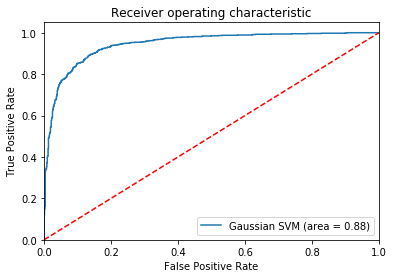

In [60]:
svm_estimator = grid_search_svm.best_estimator_
roc = plot_roc_curve(svm_estimator, features_test, labels_test, title="Gaussian SVM")
roc.show()


Learning curve for the Gaussian SVM
The graph shows that we have a problem with overfitting(high variance). Perhaps adding more training samples will most likely increase generalization and the variance will be reduced.

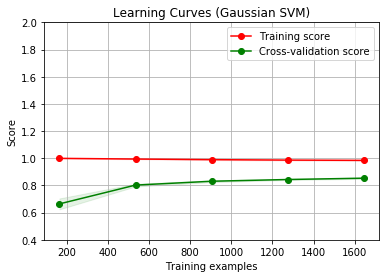

In [61]:
title = "Learning Curves (Gaussian SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)

plot_learning_curve(grid_search_svm.best_estimator_, title, features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
# print(plt.rcParams["figure.figsize"])
# plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

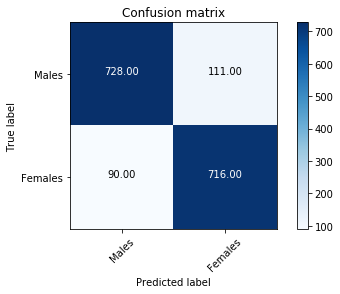

In [62]:
cnf_matrix = confusion_matrix(labels_test, grid_search_svm.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

In [63]:
#Basic Random Forest¶

np.random.seed(123456)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

In [64]:
forest_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components=150)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', RandomForestClassifier(criterion='gini'))])

forest_pipeline.fit(features_train, labels_train)

print("Test score: {}".format(forest_pipeline.score(features_test, labels_test))) # 0.7698846387370978
print("Train score: {}".format(forest_pipeline.score(features_train, labels_train)))

Test score: 0.7969604863221884
Train score: 0.9997393797237425


In [65]:
#tune

kfold = StratifiedKFold(n_splits=3)
forest_params = dict(clf__n_estimators = [1500, 2000], clf__max_depth=[2, 3])

grid_search_forest = GridSearchCV(
    forest_pipeline, param_grid=forest_params, cv=kfold, return_train_score=True, n_jobs=6)

start = time.time()
grid_search_forest.fit(features_train, labels_train)
end = time.time()

In [66]:

print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_forest.cv_results_['params'])))

GridSearchCV took {99.88} seconds for 4 candidate parameter settings.


In [67]:
grid_search_forest.best_params_ 

{'clf__max_depth': 3, 'clf__n_estimators': 1500}

In [68]:
print("Test score: {}".format(grid_search_forest.best_estimator_.score(features_test, labels_test))) # 0.7741347905282332
print("Train score: {}".format(grid_search_forest.best_estimator_.score(features_train, labels_train))) # 0.81953125
print("Classification Report")
print(classification_report(labels_test, grid_search_forest.predict(features_test)))

Test score: 0.7787234042553192
Train score: 0.8269481365650247
Classification Report
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       839
         1.0       0.75      0.83      0.79       806

    accuracy                           0.78      1645
   macro avg       0.78      0.78      0.78      1645
weighted avg       0.78      0.78      0.78      1645



In [69]:
print_grid_search_results(grid_search_forest, splits=3)

,param_clf__max_depth,n_estimators,split0_test,split1_test,split2_test,mean_test,std_test_score,rank_test,split0_train,split1_train,split2_train,mean_train,std_train_score
2,3,1500,0.752932,0.774042,0.789679,0.772218,0.015057,1,0.833464,0.845582,0.843628,0.840891,0.005312
3,3,2000,0.749023,0.766224,0.787334,0.767527,0.015668,2,0.837764,0.844410,0.846755,0.842976,0.003808
1,2,2000,0.731822,0.767787,0.793589,0.764399,0.025330,3,0.800625,0.817045,0.812353,0.810008,0.006905
0,2,1500,0.736513,0.760751,0.783425,0.760229,0.019155,4,0.795152,0.811181,0.810399,0.805577,0.007378


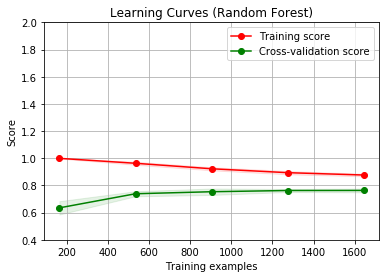

In [70]:

# Time: ~1.5 min
# prints learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)
plot_learning_curve(grid_search_forest.best_estimator_, 
                    "Learning Curves (Random Forest)", 
                    features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)
plt.show()

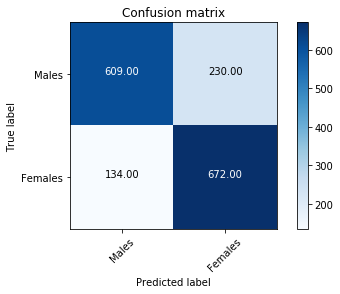

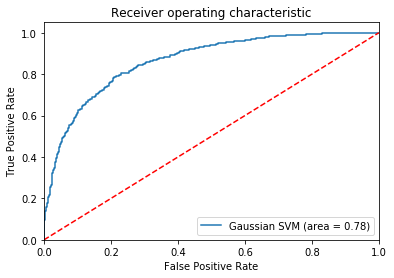

In [71]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(labels_test, grid_search_forest.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

# prints ROC curve
forest_estimator = grid_search_forest.best_estimator_
roc = plot_roc_curve(forest_estimator, features_test, labels_test, title="Gaussian SVM")
roc.show()

# Adaptive Boost
Basic AdaBoost with Decision Tree

In [72]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345) # , random_state=12345

tree = DecisionTreeClassifier(max_depth=1)

ada_boost_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components=150)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', AdaBoostClassifier(tree))])

ada_boost_pipeline.fit(features_train, labels_train)
print("Test score: {}".format(ada_boost_pipeline.score(features_test, labels_test))) # 0.7644201578627808
print("Train score: {}".format(ada_boost_pipeline.score(features_train, labels_train)))

Test score: 0.7604863221884498
Train score: 0.8193901485535575


In [73]:

start = time.time()
params = dict(clf__n_estimators=[100, 150], clf__learning_rate=[0.1, 0.35, 0.5]) # add 50
kfold = StratifiedKFold(n_splits=5)

ada_boost_grid_search = GridSearchCV(
    ada_boost_pipeline, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)
ada_boost_grid_search.fit(features_train, labels_train)

end = time.time()
print("Time: {}".format(end - start))
ada_boost_grid_search

Time: 103.03278136253357


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=150, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('scaler_1',
                                        StandardScaler(copy=Tru...
                                                                                                 min_samples_split=2,
            

In [74]:
print("Best params: {}".format(ada_boost_grid_search.best_params_))
print("Mean test score: {}".format(ada_boost_grid_search.best_estimator_.score(features_test, labels_test))) 
# 0.8032786885245902
print("Mean train score: {}".format(ada_boost_grid_search.best_estimator_.score(features_train, labels_train))) 
# 0.88203125
print_grid_search_results(ada_boost_grid_search, splits=5)
# Best params: {'learning_rate': 0.35, 'n_estimators': 150}
print("Classification Report")
print(classification_report(labels_test, ada_boost_grid_search.predict(features_test)))

# Confusion matrix
cnf_matrix = confusion_matrix(labels_test, ada_boost_grid_search.best_estimator_.predict(features_test))
np.set_printoptions(precision=2)

Best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 150}
Mean test score: 0.8048632218844984
Mean train score: 0.8722960646338285
Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       839
         1.0       0.80      0.81      0.80       806

    accuracy                           0.80      1645
   macro avg       0.80      0.80      0.80      1645
weighted avg       0.81      0.80      0.80      1645



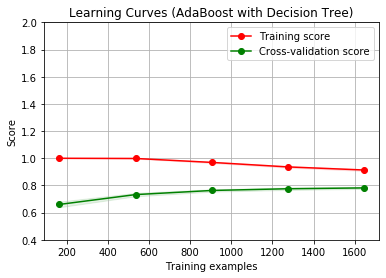

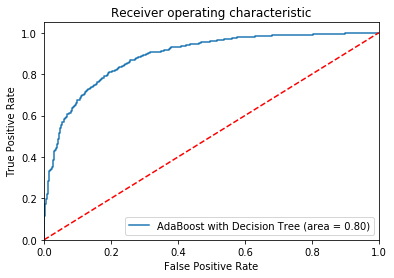

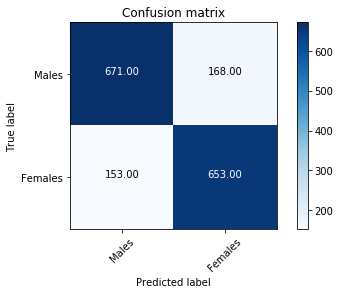

In [75]:
ada_boost_estimator = ada_boost_grid_search.best_estimator_
# prints learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.7, random_state=0)
plot_learning_curve(ada_boost_estimator, 
                    "Learning Curves (AdaBoost with Decision Tree)", 
                    features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)
plt.show()

# prints ROC curve
roc = plot_roc_curve(ada_boost_estimator, features_test, labels_test, title="AdaBoost with Decision Tree")
roc.show()

# Plot confusion matrix
cnf_matrix = confusion_matrix(labels_test, ada_boost_estimator.predict(features_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

# Experimental: attempt to combine models
Now I'll try to combine models to get a better result. My idea is the following:

We have $k$ different hypothesis(for example Logistic Regression, SVM and Decision Tree). Then $h_k(X)=y$, where $k&gt;1$, $X$ is the feature matrix, $y$ is the labels vector. Then we can construct a new dataset and hypothesis that will look like this:

For $h_1, h_2, ...,h_k$ I'll chose hypothesis with different nature. For example I can chose $h_{k}\{k=1,2\}$ where $h_1$ is a logistic regression and $h_2$ is a random forest. These are two completely different species. My intuition suggests that this should be the case - to choose completely different algorithms. It makes no sense, for example, to get two types of logistic regresion or random forest and decision tree, because they are very similar. Later I can make more features with polynomial features. For $H$ I can try a simple hypothesis like logistic regression.

Now I will generate new features from Logistic regression model and AdaBoost Model.

In [76]:
new_features = np.empty(shape=(0,2))
for image in features:
    # svm = svm_result = grid_search_svm.predict_proba([image])[0][1]
    logr = grid_search_logistic_regresion.predict_proba([image])[0][1]
    adabst = ada_boost_grid_search.predict_proba([image])[0][1]
    
    new_features = np.append(new_features, [[logr, adabst]], axis=0)

In [77]:

new_data = pd.DataFrame({"Logistic Regression":new_features[:,0], "Ada Boost":new_features[:,1], "labels":labels})
new_data.head()

,Logistic Regression,Ada Boost,labels
0,0.080542,0.496118,0.0
1,0.252967,0.498307,0.0
2,0.229819,0.501418,0.0
3,0.821899,0.503841,1.0
4,0.065035,0.487890,0.0


In [78]:
new_features_train, new_features_test, labels_train, labels_test = train_test_split(
    new_features, labels, train_size=0.7, test_size=0.3, random_state=42)

pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=2, interaction_only=False)),
                       ('lr', LogisticRegression())])

pipe.fit(new_features_train, labels_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [79]:
pipe.score(new_features_test, labels_test)

0.8601823708206687

In [80]:

pipe.score(new_features_train, labels_train)

0.8590044305446963

In [81]:

grid_search_experiment = GridSearchCV(
    pipe, param_grid=dict(lr__C = [0.1, 0.5, 1, 10]), cv=StratifiedKFold(n_splits=8))
grid_search_experiment.fit(new_features_test, labels_test)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
  

In [82]:
grid_search_experiment.score(new_features_test, labels_test)

0.8632218844984803

In [83]:
grid_search_experiment.score(new_features_train, labels_train)

0.8569194683346364

In [84]:
grid_search_experiment.best_params_

{'lr__C': 1}

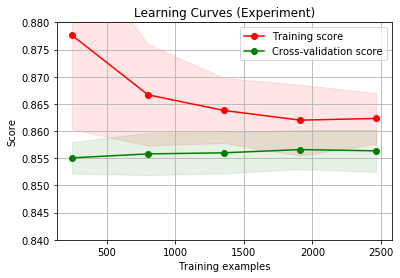

In [85]:

cv = ShuffleSplit(n_splits=10, test_size=0.55, random_state=0)
plot_learning_curve(grid_search_experiment.best_estimator_, 
                    "Learning Curves (Experiment)", 
                    new_features, labels, ylim=(0.84, 0.88), cv=cv, n_jobs=4)
plt.show()

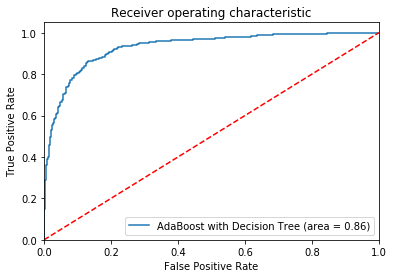

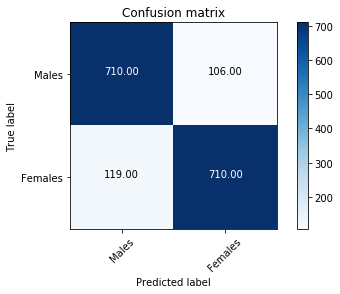

In [86]:
experiment = grid_search_experiment.best_estimator_
# prints ROC curve
roc = plot_roc_curve(experiment, new_features_test, labels_test, title="AdaBoost with Decision Tree")
roc.show()

# Plot confusion matrix
cnf_matrix = confusion_matrix(labels_test, experiment.predict(new_features_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.array(["Males", "Females"]), title='Confusion matrix')
plt.show()

In [87]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=12345)

# Prints the models ordered by the mean test score
logistic_regression_score = grid_search_logistic_regresion.best_estimator_.score(features_test, labels_test)
linear_svm_score = grid_search_linear_svm.best_estimator_.score(features_test, labels_test)
gaussin_svm_score = grid_search_svm.best_estimator_.score(features_test, labels_test)
random_forest_score = grid_search_forest.best_estimator_.score(features_test, labels_test)
ada_boost_score = ada_boost_grid_search.best_estimator_.score(features_test, labels_test)

res = pd.DataFrame({'Classificator': ["Logistic Regressin", "Linear SVM", "Gaussian SVM", 
                                "Random Forest", "AdaBoost with Decision tree"], 
                   'Mean test score': [logistic_regression_score, linear_svm_score, gaussin_svm_score, 
                                       random_forest_score, ada_boost_score]})

res.sort_values(by='Mean test score', inplace=True, ascending=False)
res.head()

,Classificator,Mean test score
2,Gaussian SVM,0.877812
0,Logistic Regressin,0.854103
1,Linear SVM,0.851064
4,AdaBoost with Decision tree,0.804863
3,Random Forest,0.778723


In [89]:
FACE_CASCADE_PATH = r'D:\2nd_semester\bigdatascience\project\face_data\face.xml'

def predict(image):
    """ 
    Display the result of several models 
    If a model does not exists - try to load a saved model from the local storage
    If a model exists but is not saved - save a model to a local sotrage
    If a model is already saved - use the model from the memory (do not use the saved model)
    """
    svm_model = None
    logistic_regression_model = None
    ada_boost_model = None
    
    row_image = image.ravel()
    
    names = [('grid_search_svm', './saved_models/svm_model.sav', 'Gaussian SVM model'),
             ('grid_search_logistic_regresion','./saved_models/logistic_regression_model.sav',
              'Logistic Regression model'),
             ('ada_boost_grid_search', './saved_models/ada_boost_model.sav', 'AdaBoost model')]

    res = ""
    for tuple_name in names:
        model_name = tuple_name[0]
        location = tuple_name[1]
        title = tuple_name[2]
        
        try:
            if not os.path.exists(location) and model_name in globals():
                model = (globals()[model_name]).best_estimator_
                pickle.dump(model, open(location, 'wb'))
                print("A model is dumped.")
            elif os.path.exists(location) and not model_name in globals():
                model = pickle.load(open(location, 'rb'))    
                print("Warn: '{}' model is loaded from the local storage.".format(model_name))
            elif model_name in globals():
                model = (globals()[model_name]).best_estimator_
                print("{} model is used from the memory.".format(model_name))
            else:
                print("Error: Can't find a model. Please build {} model first.".format(model_name))
            res += get_result(model.predict_proba([row_image]), title) + "\n\n"
        except Exception as ex:
            print(ex)
    
    if 'grid_search_experiment' in globals():
        lr = grid_search_logistic_regresion.predict_proba([row_image])[0][1]
        ada = ada_boost_grid_search.predict_proba([row_image])[0][1]

        experiment = grid_search_experiment.predict_proba([[lr, ada]])
        res += get_result(experiment, "Experiment") + "\n\n"
         
    plt.figure()
    plt.imshow(image.reshape(40,40), cmap=plt.cm.bone)
    plt.annotate(res,xy=(0,0), xytext=(45,40), fontsize=20)    

    
def get_result(result_proba, title):
    """ Returns a result with model title """
    if result_proba[0][1] > .5:
        res = "Man({:.2f}%)".format(result_proba[0][1]*100.)
    else:
        res ="Woman({:.2f}%)".format(result_proba[0][0]*100.)
        
    return "{}: {}".format(title, res)

In [90]:
def recognize_faces_from_frame():
    # data:       https://github.com/opencv/opencv/tree/master/data/haarcascades
    # faces, see: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    my_image = None

    cap = cv2.VideoCapture(0)
    is_running = True
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # looks for faces within the image
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        w = 0 #30
        h = 0 #50
        for (x, y, width, height) in faces:
            # draws a rectangle around the detected face
            cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
            face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]

            if cv2.waitKey(1) == ord('q') or not is_running:
                resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
                try:
                    predict(resized)
                except Exception as ex:
                    print("Error: {}".format(ex))           
                is_running = False

        cv2.imshow('frame', frame)

        if not is_running:
            break

    cap.release()
    cv2.destroyAllWindows()

recognize_faces_from_frame()

KeyboardInterrupt: 

In [1]:
def recognize_faces_from_image(image):
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    w = 0
    h = 0
    for (x, y, width, height) in faces:
        #cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
        face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        try:
            predict(resized)
        except Exception as ex:
            print("Error: {}".format(ex))

recognize_faces_from_image(cv2.imread(r'D:\2nd_semester\bigdatascience\project\face_data\lfw_funneled\Aaron_Guiel\Aaron_Guiel_0001.jpg'))

NameError: name 'cv2' is not defined